In [2]:
using CUDA, Flux

In [3]:
using Flux: @epochs, onehotbatch, onehot, onecold, logitcrossentropy, mse, throttle

In [36]:
using StatsPlots

### Set device
gpu #3 is reserved for computation and modelling

In [4]:
device!(3)

In [5]:
device()

CuDevice(3): Tesla V100-DGXS-32GB

### Prep data

Start with simulated data  
X 6000x52  
Y 6000x2 two class  

*Note:* Flux actually organize data in different way,   
    X m, N    
    Y k, N    

N being number observations
m being number features
k beging number class

In [21]:
N = 6000   # observations
k = 2      # classes
v = 52     # variables, features, there is a reason f or m not assigned for this

6000

In [78]:
X = cu(rand(52, N))

52×6000 CuArray{Float32,2}:
 0.545672   0.450415   0.485326   …  0.875336   0.336365  0.162574
 0.758937   0.093945   0.705532      0.108258   0.745527  0.681416
 0.427908   0.377189   0.145747      0.819008   0.380907  0.664879
 0.260136   0.378708   0.829663      0.119683   0.519667  0.0884984
 0.998986   0.0681456  0.364334      0.5524     0.937572  0.407478
 0.743362   0.0590551  0.340839   …  0.830969   0.160703  0.174659
 0.222908   0.113041   0.621122      0.95324    0.950617  0.280767
 0.627556   0.440959   0.284897      0.132627   0.700404  0.383878
 0.990422   0.5026     0.859709      0.246702   0.803085  0.816795
 0.0137885  0.957386   0.295781      0.155757   0.276308  0.341159
 0.557651   0.260157   0.132258   …  0.0200478  0.321586  0.0509595
 0.836046   0.195471   0.724913      0.764316   0.300155  0.123254
 0.344581   0.822168   0.559964      0.76363    0.867897  0.854299
 ⋮                                ⋱                       
 0.107039   0.735643   0.547856   …  0.2

In [24]:
Y = cu(rand([0, 1], 2, N))

2×6000 CuArray{Int64,2}:
 1  0  0  0  0  0  0  1  1  1  1  1  1  …  0  0  0  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  1  1  0  0  0  0  0  0     0  0  0  1  1  0  0  0  1  1  0  0

### Vanilla MLP
could've called it deep learning with 4 layers , lol, ahem

In [26]:
m = Chain(
        Dense(52, 26, relu),
        Dense(26, 12, relu),
        Dense(12, 6, relu),
        Dense(6, 2), 
        softmax
) |> gpu

Chain(Dense(52, 26, relu), Dense(26, 12, relu), Dense(12, 6, relu), Dense(6, 2), softmax)

In [17]:
loss(x, y) = logitcrossentropy(m(x), y)

loss (generic function with 1 method)

In [18]:
opt = ADAM() |> gpu

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [27]:
@epochs 10 Flux.train!(loss, params(m), [(X, Y)], opt)

┌ Info: Epoch 1
└ @ Main /home/jovyan/.julia/packages/Flux/05b38/src/optimise/train.jl:114


In [31]:
ŷ = m(X) |> cpu

2×6000 Array{Float32,2}:
 0.466942  0.496121  0.531404  0.529782  …  0.497813  0.46804  0.472824
 0.533058  0.503879  0.468596  0.470218     0.502187  0.53196  0.527176

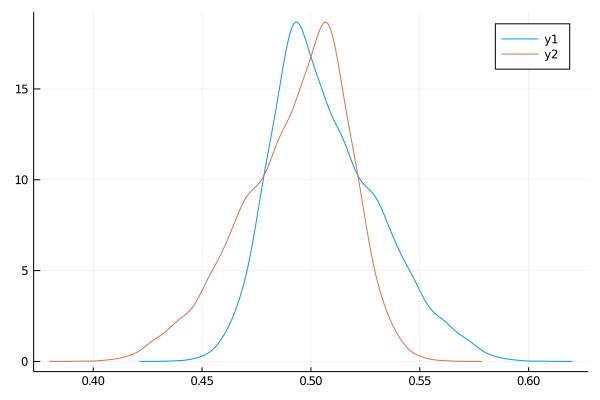

In [38]:
density(transpose(ŷ))

### Autoencoder

In [98]:
encoder = Chain(
                Dense(52, 26, tanh),
                Dense(26, 12)
            )  |> gpu
decoder = Chain(
                Dense(12, 26, tanh),
                Dense(26, 52)
            )  |> gpu

Chain(Dense(12, 26, tanh), Dense(26, 52))

In [99]:
m2 = Chain(encoder, decoder) 

Chain(Chain(Dense(52, 26, tanh), Dense(26, 12)), Chain(Dense(12, 26, tanh), Dense(26, 52)))

In [100]:
loss(x) = mse(m2(x), x)

loss (generic function with 2 methods)

In [82]:
opt = ADAM() # |> gpu

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [83]:
# evalcb = throttle(() -> @show(loss(train_data[1])), args.throttle)

In [ ]:
# @epochs 50 Flux.train!(loss, params(m), zip(X), opt, cb = evalcb)
@epochs 50 Flux.train!(loss, params(m2), [(X)], opt)

#### Visualize the learnt latent representation 

In [104]:
latent = encoder(X) |> cpu

12×6000 Array{Float32,2}:
 -0.479961   -0.974436  -0.809618   …  -0.831369  -0.462959   -0.798206
  1.15558     1.51269    1.40841        0.975582   0.844101    1.30034
 -0.204848    0.118009   0.169703      -0.164664  -0.0817529  -0.167717
  0.585287    0.508559   0.739102       0.340059   0.409749    0.307999
  1.77553     1.26045    1.60672        1.8501     2.32772     1.72835
 -0.0291381  -0.213116  -0.105193   …   0.272246  -0.186772   -0.0340506
 -0.400757   -0.288816  -0.204289      -0.4523    -0.671118   -0.403428
  1.20008     0.742866   1.11644        0.909135   1.35956     1.01567
 -0.103114   -0.247204   0.0750963     -0.277734   0.0724972   0.00274306
  1.09346     1.02668    1.11637        0.744459   0.77776     0.945131
 -1.02648    -1.62617   -1.52517    …  -1.2871    -1.06105    -1.3843
  1.55238     1.33341    1.26029        1.4449     1.18625     1.19483

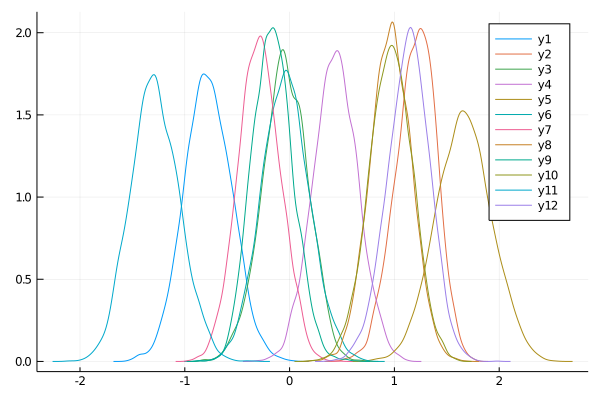

In [105]:
density(transpose(latent))

### Now what? 
Add in a bit more complexity?   
CNN ?  
CAE ? 
VAE ?   